In [144]:
%matplotlib inline
import re
import os
import numpy as np

import psycopg2
import psycopg2.extras
from itertools import chain
from collections import Counter, defaultdict
import requests
import imageio

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import textwrap
from io import BytesIO
from hashlib import md5
from IPython.display import display, HTML

from itertools import chain
import mwparserfromhell

from keras.models import Model,Sequential
from keras.layers import Embedding, Dense, Input, Lambda, Reshape, merge, Flatten
import keras.backend as K
from keras.layers.merge import Dot
from sklearn.manifold import TSNE
from keras_tqdm import TQDMNotebookCallback

The fetch_image function below fetches an image from wikipedia given a wikipedia id for that image:

In [145]:
OBJ_STR='book'

In [146]:
IMAGE_PATH_EN = 'http://upload.wikimedia.org/wikipedia/en/%s/%s/%s'
IMAGE_PATH_COMMONS = 'http://upload.wikimedia.org/wikipedia/commons/%s/%s/%s'
image_cache = OBJ_STR+'_images'

def fetch_image(image_name):
    if not image_name: 
        return False
    file_path = os.path.join(image_cache, image_name)
    if os.path.isfile(file_path): #if image already exist, simply return 
        #Image.open(file_path).show()
        return True
    else:
        m = md5() #hash function producing 128 bit hash value from text 
        m.update(image_name.encode('utf-8'))
        c = m.hexdigest()
        #print c
        path1 = IMAGE_PATH_EN % (c[0], c[0:2], image_name)
        #print path
        r = requests.get(path1)
        if r.status_code == 404:
            path2 = IMAGE_PATH_COMMONS % (c[0], c[0:2], image_name)
            r = requests.get(path2)
            if r.status_code == 404:
                #print 'status code 404 retrieving ',image_name
                #print 'both paths failed', path1, path2
                return False
        try:
            image = Image.open(BytesIO(r.content))
        except IOError:
            return False
        except ValueError:
            return False
        try:
            image.save(file(file_path, 'w'))
        except IOError as err:
            print image_name, err.message
            return False
        image.thumbnail((240, 640), Image.ANTIALIAS)
        res = BytesIO()
        if image.mode == 'P':
            image = image.convert('RGB')
        try:
            image.save(res, 'WebP', quality=15)
        except IOError as err:
            print image_name, err.message
            return False
        #Image.open(file_path).show()
        return True

fetch_image('TheGreatGatsby_1925jacket.jpeg')

True

In [147]:
postgres_conn = psycopg2.connect('dbname=wikidb user=luliu')
postgres_cursor = postgres_conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

setup a connection to postgres, fetch the 500 most popular items and then extract for each the item name, the image for the item and the outgoing links from that page

In [148]:
print 'Getting top %ss...'%(OBJ_STR)
postgres_cursor.execute(
    "SELECT wikipedia.*, wikistats.viewcount FROM wikipedia "
    "JOIN wikistats ON wikipedia.title = wikistats.title WHERE wikipedia.infobox like '%book%' "
    "ORDER BY wikistats.viewcount DESC limit 500"
)
print 'done'

Getting top books...
done


retrieve image files from the web, create an array to store the items 

In [149]:
#create an image file for the book if failed to retrieve from the web 
def create_image(title):
    image_name=title.replace(' ','_')+'.jpg'
    file_path = os.path.join(image_cache, image_name)
    if os.path.isfile(file_path): #if image already exist, simply return 
        return image_name
    img = Image.new('RGB', (200, 300))
    draw = ImageDraw.Draw(img)
    draw.text((20, 70), textwrap.fill(title,15) ,font=ImageFont.truetype("/Users/luliu/Library/Fonts/Tox Typewriter.ttf", 20))
    img.save(file_path, "JPEG")  
    return image_name

#turn image name into proper image file name for web retrieval 
def get_clean_image_name(original):
    image_name=original.strip()
    if not image_name:
        return None
    re_image_name=re.compile('([\w\-\(\)\'\.,]+\.(?:jpg|png|jpeg|gif))', re.I|re.M|re.U)
    image_name=image_name.replace(' ','_')
    result=re_image_name.search(image_name)
    if result:
        image_name=result.group().strip("_")
    try:
        if image_name[0].upper()!=image_name[0]: #already capitalized leave untouched
            image_name=image_name.capitalize()
    except:
        print 'has empty image_name string!!!!!!!!!'
    return image_name

item_list = []
for item in postgres_cursor:
    wikicode = mwparserfromhell.parse(item['wikitext'])
    image_name = None
    successful = False #flag for retriveing image online 
    for template in wikicode.filter_templates():
        if template.name.lower().startswith('infobox '):
            for param in template.params:
                key = param.name.strip()                    
                if key == 'image':
                    image_name=get_clean_image_name(param.value) 
                    break
    if image_name:
        successful = fetch_image(image_name)
    if image_name is None or not successful: 
        #print 'cannot find image for ',item['title']
        #print 'creating an image for this item...'
        image_name=create_image(item['title'])
        print image_name, 'created'
    item_list.append((item['title'], image_name, set(unicode(x.title) for x in wikicode.filter_wikilinks()), item['viewcount']))

num_items=len(item_list)
num_items

Guinness_World_Records.jpg created
The_Stranger_(novel).jpg created
Lar_Gand.jpg created
Encyclopædia_Britannica.jpg created
Dirk_Gently's_Holistic_Detective_Agency.jpg created
Katana_(comics).jpg created
A_Bridge_Too_Far_(film).jpg created
Into_the_Wild_(book).jpg created
Tank_Girl.jpg created
Gary_Larson.jpg created
Cat's_Cradle.jpg created
Goosebumps.jpg created
The_History_of_the_Decline_and_Fall_of_the_Roman_Empire.jpg created
Rubaiyat_of_Omar_Khayyam.jpg created
The_Idiot.jpg created
Beyond_Good_and_Evil.jpg created
Magic_Tree_House.jpg created
Little_House_on_the_Prairie.jpg created
Aubrey–Maturin_series.jpg created
The_Devil_and_Daniel_Webster.jpg created
Left_Behind.jpg created
Anabasis_(Xenophon).jpg created
Liar's_Poker.jpg created


500

In [150]:
item_list[:3]

[("The Handmaid's Tale",
  u'TheHandmaidsTale(1stEd).jpg',
  {u'Advanced Placement',
   u'Afghanistan',
   u'Aldous Huxley',
   u'Alexander Gamayunov',
   u'Amanda Green (dancer)',
   u'America (magazine)',
   u'American Library Association',
   u'Arranged Marriage',
   u'Arthur C. Clarke Award',
   u'Audie Award',
   u'Audio file format',
   u'BBC One',
   u'BBC Radio 4',
   u'BBC World Service',
   u'Bantustan',
   u'Baptist',
   u'Basingstoke',
   u'Bilhah',
   u'Booker Prize',
   u'Books of Kings',
   u'Brainwashing',
   u'Brave New World',
   u'Breakfast News',
   u'CBC Music',
   u'CBC News',
   u'CBC Radio',
   u'Cambridge, Massachusetts',
   u'Canada',
   u'Canadian Library Association',
   u'Canadian literature',
   u'Category:1980s science fiction novels',
   u'Category:1985 Canadian novels',
   u'Category:Boston in fiction',
   u'Category:Canadian novels adapted into films',
   u'Category:Canadian speculative fiction novels',
   u'Category:Debut speculative fiction novels',


In [142]:
#serialize items_list array and store in file 
import pickle
pickle.dump( item_list, open( "item_list.p", "wb" ) )

In [170]:
item_list=pickle.load(open("item_list.p","rb"))

extract all the outgoing links (refs) and keep the ones that are used more than once, less than 50 times (refs that are shared too often does not provide much information).

In [171]:
ref_counts = Counter()
for _, _, refs, _ in item_list:
    ref_counts.update(refs)
all_shared_refs = [ref for ref, count in ref_counts.items() if 1<count<50] #if a ref is shared by too many books, then its not very important 
ref_to_id = {ref: idx for idx, ref in enumerate(all_shared_refs)}
item_to_id = {title: idx for idx, (title, _, _, _) in enumerate(item_list)}
len(all_shared_refs), len(ref_counts)


(7419, 41298)

In [172]:
[ref for ref, count in ref_counts.items() if count>50]

[u'Category:British novels adapted into films',
 u'Time (magazine)',
 u'The New York Times',
 u'Category:American novels adapted into films',
 u'Paperback',
 u'Hardcover',
 u'Category:Novels adapted into television programs',
 u'BBC Radio 4',
 u'BBC',
 u'The Guardian']

In [173]:
#create the items_refs that hold the refs for each item
items_refs = defaultdict(set)
for item, image, refs, viewcounts in item_list:
    item_id = item_to_id[item]
    ref_ids = set(ref_to_id.get(ref) for ref in refs if ref_to_id.get(ref) is not None)
    items_refs[item_id]|=ref_ids
len(items_refs)

500

In [174]:
#for each ref, the list of items that reference to it 
refs_items = defaultdict(set)
for item_id, ref_ids in items_refs.items():
    for ref_id in ref_ids:
        refs_items[ref_id].add(item_id)
refs_items = list(refs_items.items())
len(refs_items)

7419

check that the most shared refs are meaningful refs

In [175]:
sorted_refs=sorted(refs_items,key=lambda item: len(item[1]),reverse=True)
for id,_ in sorted_refs[-10:]:
    print all_shared_refs[id]

Cirith Ungol
Vancouver
Ultron
Prohibition in the United States
Gene Wilder
Explosive material
Dover
Nikolai Chernyshevsky
The Old Curiosity Shop
Category:Books about sovereignty


use word2vec skipgram embedding model to map the books into a lower dimension vector space.     
use the resulting embedding vectors to find similarities among books 

In [176]:
#data generation functions
import random
def data_generator(refs_items,negative_ratio=5):
    random.shuffle(refs_items)
    for ref_id,item_ids in refs_items:
        if len(item_ids)<2: continue 
        a,b=random.sample(item_ids,2)
        yield a,b,1
        seen=item_ids.copy()
        left=negative_ratio
        while left>0:
            neg_b=random.randrange(num_items)
            left-=1
            if not neg_b in seen:
                seen.add(neg_b)
                yield a, neg_b, 0
       
def batchify(gen, batch_size):
    targets, contexts, labels = [], [], []
    count=0
    while True:
        for a, b, label in gen():
            targets.append(a)
            contexts.append(b)
            labels.append(label)
            count+=1
            if count > batch_size:
                yield [np.asarray(targets), np.asarray(contexts)], np.asarray(labels)
                count=0
                del targets[:]
                del contexts[:]
                del labels[:]
print next(batchify(lambda: data_generator(refs_items), batch_size=100))


([array([279, 279, 279, 279, 279, 279, 191, 191, 191, 191, 191, 191, 204,
       204, 204, 204, 204, 204,  74,  74,  74,  74,  74,  74, 386, 386,
       386, 386, 386, 386,  43,  43,  43,  43,  43,  43, 241, 241, 241,
       241, 241, 241, 268, 268, 268, 268, 268, 268, 406, 406, 406, 406,
       406, 406, 227, 227, 227, 227, 227, 227,  19,  19,  19,  19,  19,
        19, 381, 381, 381, 381, 381, 381, 464, 464, 464, 464, 464, 464,
       226, 226, 226, 226, 226, 226, 208, 208, 208, 208, 208, 208,  61,
        61,  61,  61,  61,  61, 306, 306, 306, 306, 306]), array([135, 145, 313, 289, 200, 399, 406,  70, 305,   1, 339, 471, 490,
        50, 131,  15, 360, 450,  52, 111, 130, 200,  91, 313, 328, 220,
       293, 482, 493,  61, 189, 457, 308,  69, 184, 240,  31, 236,  41,
        48, 387, 487, 394, 177, 498,  59, 456, 427, 256, 296, 364, 365,
       465, 156, 290, 461, 411, 134,  30, 319, 486, 459, 332, 246, 105,
       375, 118, 421,  78, 222,  11, 140, 279, 314, 489, 491, 238, 455,
   

In [232]:
#generate a skipgram word2vec model
def get_model(vocab_size=500,embed_size=50):
    input_target=Input((1,))
    input_context=Input((1,))
    embedding=Embedding(vocab_size, embed_size,input_length=1, embeddings_initializer='glorot_uniform',
                        name='embedding')
    target = embedding(input_target) #look up an embedding vector 
    target = Reshape((embed_size, 1))(target)
    context = embedding(input_context)
    context = Reshape((embed_size, 1))(context)

    dot_product = merge([target, context], mode='dot', dot_axes=1)
    dot_product = Reshape((1,))(dot_product)
    # add the sigmoid output layer
    output = Dense(1, activation='sigmoid')(dot_product)

    model = Model(input=[input_target, input_context], output=output)
    model.compile(loss='mse', optimizer='nadam',metrics=['accuracy'])
    return model

In [233]:
model=get_model(vocab_size=500,embed_size=20)
print model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_47 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
input_48 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 1, 20)         10000       input_47[0][0]                   
                                                                   input_48[0][0]                   
____________________________________________________________________________________________________
reshape_54 (Reshape)             (None, 20, 1)         0           embedding[0][0]         

/Users/luliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/luliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


In [234]:
#check data validity
print next(batchify(lambda: data_generator(refs_items), batch_size=1000))[1]

[1 0 0 ..., 0 0 1]


In [235]:
model.fit_generator(
    #works best when the batch size = vocab size 
    batchify(lambda: data_generator(refs_items), 512), 
    epochs=40,
    steps_per_epoch=1000,
    verbose=0,
    callbacks=[TQDMNotebookCallback(leave_inner=True,leave_outer=True)]
)
#training result is differnt (initialization is different)
#converges quickly (within 20 epochs )
#best result is loss=0.06

In [222]:
acc= model.history.history['acc']
loss= model.history.history

['acc', 'loss']

In [236]:
def get_normalized_weights(weights):
    lens = np.linalg.norm(weights, axis=1)
    normalized = (weights.T / lens).T
    print np.linalg.norm(normalized[0]), normalized.shape
    return normalized


embed = model.get_layer('embedding')
weights = embed.get_weights()[0]
normalized=get_normalized_weights(weights)

1.0 (500, 20)


In [237]:
#check nearest neighbors to see it works 

In [238]:
#find neighbors in the vector space 
def find_neighbors(M,item_name,k):
    item_id=item_to_id[item_name]
    diff=M-M[item_id]
    distances=np.linalg.norm(diff,axis=1)
    #print distances
    closest=np.argsort(distances)[:k]
    print closest
    for c in closest:
        print c, item_list[c][0],distances[c]
find_neighbors(normalized,"This Side of Paradise",20) 

[373 143 341 254 330 476 495 110 151  90 117 177  26 335 449 427 388  75
 167  53]
373 This Side of Paradise 0.0
143 The Bell Jar 0.715775
341 The Screwtape Letters 0.738604
254 United States Code 0.761388
330 Elite (video game) 0.771314
476 Homage to Catalonia 0.778723
495 A Scanner Darkly 0.787228
110 Design Patterns 0.802366
151 A Bridge Too Far (film) 0.804281
90 The Curious Incident of the Dog in the Night-Time 0.820855
117 Little Women 0.823194
177 Their Eyes Were Watching God 0.841646
26 Porno (novel) 0.853038
335 So Long, and Thanks for All the Fish 0.859115
449 A Separate Peace 0.872955
427 Bone (comics) 0.873278
388 Native Son 0.874562
75 Infinite Jest 0.879156
167 The Invisible Man 0.893509
53 The Old Man and the Sea 0.89886


In [168]:
def map_to_2d(M):
    model = TSNE(n_components=2, random_state=0)
    return model.fit_transform(M)

500


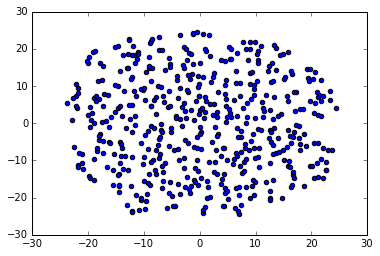

In [169]:
def visualize_data(normalized):
    xy=map_to_2d(normalized)
    print len(xy)
    plt.scatter(xy[:,0], xy[:,1])
    plt.show()
    return xy
xy=visualize_data(normalized)

In [59]:
#create a large bitmap with all the book cover images on it
def generate_giant_poster(poster_name,items,xy):    
    w,h=144,220 #dimensions of a single poster 
    size=30 #use a 30*30 grid to display all 500 books 
    res=[]
    #neighbors coordinates for placing overlap images
    NEIGHBORS=[(x,y) for x in range(-2,3) for y in range(-2,3) if not (x==y==0)] 
    x_min = xy.T[0].min()
    y_min = xy.T[1].min()
    x_max = xy.T[0].max()
    y_max = xy.T[1].max()
    img=Image.new('RGB', (size*w,size*h))
    drw=ImageDraw.Draw(img)
    taken=[[False]*(size+1) for _ in range(size+1)] #boolean matrix to keep track of whether a grid is taken
    failure_count=0
    for item, coord in zip(items,xy):
        poster = Image.open(os.path.join(image_cache, item[1]))
        try: 
            poster.thumbnail((w,h),Image.ANTIALIAS) #use a high-quality downsampling filter to resize 
        except IOError as err:
            print err, item[1]
            pass

        x=int(size*(coord[0]-x_min)/(x_max-x_min))
        y=int(size*(coord[1]-y_min)/(y_max-y_min))
        if taken[x][y]:
            found=False
            for dx,dy in NEIGHBORS:
                u,v=x+dx,y+dy
                if 0<=u<=size and 0<=v<=size and not taken[u][v]:
                    x,y=u,v
                    found=True 
                    break
            if not found:
                failure_count+=1
        taken[x][y]=True 
        drw.rectangle((x*w,y*h,(x+1)*w,(y+1)*h),'white')
        res.append((item[0], item[1], x*w,y*h)) #save title, image_name, coordinates
        img.paste(poster,box=(x*w,y*h))
    img.save(open(poster_name+'.png', 'wb'))
    print 'could not find spot for ', failure_count, 'images'
    return res

In [60]:
res=generate_giant_poster('relu_skipgram_book_poster',item_list,xy)

could not find spot for  0 images


write the result back into the database to power the demo on webpage

In [265]:
cursor = postgres_conn.cursor()
cursor.execute('DROP TABLE IF EXISTS w2v_book_recommender')
cursor.execute('CREATE TABLE w2v_book_recommender ('
               '    wikipedia_id TEXT PRIMARY KEY,'
               '    image TEXT,'
               '    x FLOAT,'
               '    y FLOAT,'
               '    vec FLOAT[] NOT NULL DEFAULT \'{}\''
               ')')
#gin indexing for array values 
cursor.execute('CREATE INDEX w2v_book_recommender_vec ON w2v_book_recommender USING gin(vec)')
#text_pattern_ops allows pattern matching 
cursor.execute('CREATE INDEX w2v_book_recommender_name_pattern ON w2v_book_recommender USING btree(lower(wikipedia_id) text_pattern_ops)')


In [266]:
for (item_title, image_name,x,y),vec in zip(res,normalized):
    cursor.execute('INSERT INTO w2v_book_recommender (wikipedia_id, image, x, y, vec) '
                   'VALUES (%s, %s, %s, %s, %s)',(item_title,image_name, x, y, [float(v) for v in vec]))
                             

In [267]:
postgres_conn.commit()
cursor.close()

In [70]:
#get x,y ,image from w2v_book_recommender table and regenerate the poster 
postgres_conn = psycopg2.connect('dbname=my_website_developmentdb user=luliu')
cursor = postgres_conn.cursor()
cursor.execute('SELECT x,y,image from w2v_book_recommender')

In [71]:
def generate_poster_from_database(cursor,poster_name):
    w,h,size=144,220,30
    img=Image.new('RGB', (size*w,size*h))
    drw=ImageDraw.Draw(img)
    for x,y,image_name in cursor:
        x,y=int(x),int(y)
        book_cover = Image.open(os.path.join(image_cache, image_name))
        try: 
            book_cover.thumbnail((w,h),Image.ANTIALIAS) #use a high-quality downsampling filter to resize 
        except IOError as err:
            print err, item[1]
            pass
        drw.rectangle((x,y,x+w,y+h),'white')
        img.paste(book_cover,box=(x,y))
    img.save(open(poster_name+'.png', 'wb'))
    

In [72]:
generate_poster_from_database(cursor,'book_recommendation_skipgram')